# Concept 2: Bayesian Posterior Inference

## Bayes' Rule

$$
    \large{P(A|B) = \frac{P(B|A) P(A)}{P(B)}}
$$


__In words__: The probability of an event $A$ occurring, having accounted for information from $B$ occurring, $P(A|B)$, is based on prior knowledge about $A$, $P(A)$, and supporting evidence in the form of additional observations given a likelihood $P(B|A)$, normalized by the marginal probability $P(B)$.

$$
    P(A|B) = \frac{\mbox{likelihood}\ast \mbox{prior}}{\mbox{marginal distribution}}
$$

### Example (soccer games)

A soccer team plays half their games at home. It wins 60% of their home games and 30% of their away games. What is the probability that the team played an away game, given that they were victorious?

#### Solution:

$ p(H) = p(A) = 0.5$, $p(W|H) = 0.60$, $p(W|A) = 0.30$,

$$
    \begin{align}
        \begin{aligned}
            p(A|W) &= \frac{p(W|A)p(A)}{p(W)} \\
                   &= \frac{p(W|A)p(A)}{p(W|A)p(A) + p(W|H)p(H)} \\
                   &= \frac{0.30\cdot 0.50}{0.30\cdot 0.50 + 0.60\cdot 0.50} = \frac{1}{3}
        \end{aligned}
    \end{align}
$$

## Bayesian Inference

In __Bayesian inference__, we use Bayes' Rule to convert information from the prior $p_0(\theta)$ and likelihood of observing data $y$ given a proposal $\theta$, $p(y|\theta)$, to the posterior $p(\theta|y)$.

The marginal distribution in the denominator is only a normalization constant in this case since it is not a function of $\theta$ and $p(\theta|y)$ is a posterior density. Thus, we write

$$
    \large{p(\theta|y) = \frac{p(y|\theta)p_0(\theta)}{\int_{\mathbb{R}^n}p(y|\theta)p_0(\theta)d\theta}}
$$

### Example (Coin Toss)

In this example we consider a scenario in which the posterior is computed analytically, to sample directly from its density. Suppose an experiment consists of flipping a coin $N = N_1 + N_2$ times to obtain $N_1$ heads and $N_2$ tails. Then, 
$$
    Y_i(\omega) = \left\{\begin{array}{ll} 1, & \omega = H, \\ 0, & \omega = T \end{array}\right.
$$
is the random variable representing the result from the $i^{th}$ toss. We denote the parameter $\theta$ as the probability of obtaining heads. Then, as independent events, the likelihood of observing a sequence $y = [y_1,y_2,\ldots , y_N]$ with probability $\theta$, is 
$$
    \begin{align}
        \begin{aligned}
            p(y|\theta) &= \prod_{i=1}^N \theta^{y_i}(1-\theta)^{1-y_i} \\
                        &= \theta^{\sum y_i}(1-\theta)^{N-\sum y_i} \\
                        &= \theta^{N_1}(1-\theta)^{N_2}.
        \end{aligned}
    \end{align}
$$

In the absence of information, one typically considers a noninformative prior. In this case, we take the uniform prior
$$
    p_0(\theta) = \left\{\begin{array}{ll} 1, & 0 \leq \theta \leq 1, \\ 0, & \mbox{otherwise}.\end{array}\right.
$$

This yields the posterior density

$$
    \begin{align}
        \begin{aligned}
            p(\theta|y) &= \frac{\theta^{N_1}(1-\theta)^{N_2}}{\int_0^1\theta^{N_1}(1-\theta)^{N_2} d\theta} \\
            &= \frac{(N+1)!}{N_1! N_2!} \theta^{N_1} (1-\theta)^{N_2}.
        \end{aligned}
    \end{align}
$$

#### Sampling

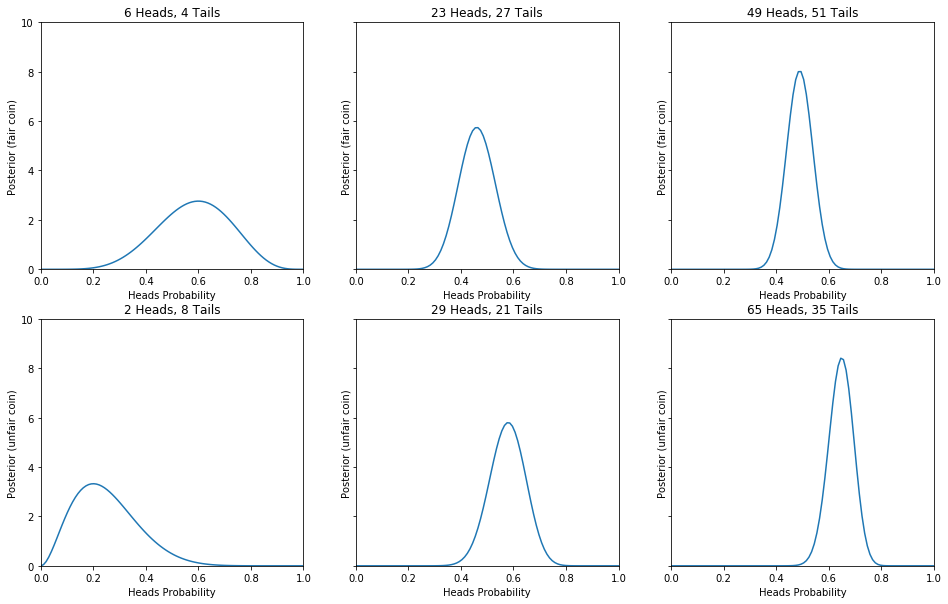

In [104]:
import numpy as np
import math as m
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

N = np.array([10,50,100])
th = np.linspace(0,1,100)
fig, axs = plt.subplots(2, 3, figsize=(16, 10), sharey=True)

for j in range(2):
    for i in range(3):
        if j==0:
            y = np.random.choice(2, N[i])
        else:
            y = np.random.choice(2, N[i], p=[0.4,0.6])
            
        N_1 = np.count_nonzero(y==1)
        N_2 = np.count_nonzero(y==0)
        post = (m.factorial(N[i]+1)/(m.factorial(N_1)*m.factorial(N_2)))*(th**N_1)*((1-th)**N_2)

        axs[j,i].plot(th,post)
        if j==0:
            axs[j,i].set_ylabel('Posterior (fair coin)')
        else:
            axs[j,i].set_ylabel('Posterior (unfair coin)')
        axs[j,i].set_xlabel('Heads Probability')
        axs[j,i].set_ylim((0,10))
        axs[j,i].set_xlim((0,1))
        axs[j,i].set_title((str(N_1)+' Heads, '+str(N_2)+' Tails'))


#### Conjugate Priors

Consider again the coin toss example with likelihood

$$
    p(y|\theta) = \theta^{N_1}(1-\theta)^{N-N_1}.
$$

Conjugate families have the property that the prior $p_0(\theta)$ and posterior $p(\theta|y)$ have the same parametric form. Then, taking $p_0(\theta)$ as a beta density such that
$$
    p_0(\theta) \propto \theta^{\alpha-1}(1-\theta)^{\beta-1}
$$
where $\alpha$ and $\beta$ are hyperparameters, we obtain
$$
    \begin{align}
        \begin{aligned}
            p(\theta|y) &  \propto \theta^{N_1}(1-\theta)^{N-N_1}\theta^{\alpha-1}(1-\theta)^{\beta-1} \\
                        &= \theta^{N_1+\alpha-1}(1-\theta)^{N-N_1+\beta-1}.
        \end{aligned}
    \end{align}
$$
This is clearly a beta density with shape parameters $N_1 + \alpha$ and $N-N_1+\beta$. Hence the beta density is a conjugate family for the binomial likelihood.    
    
    

##### Sampling

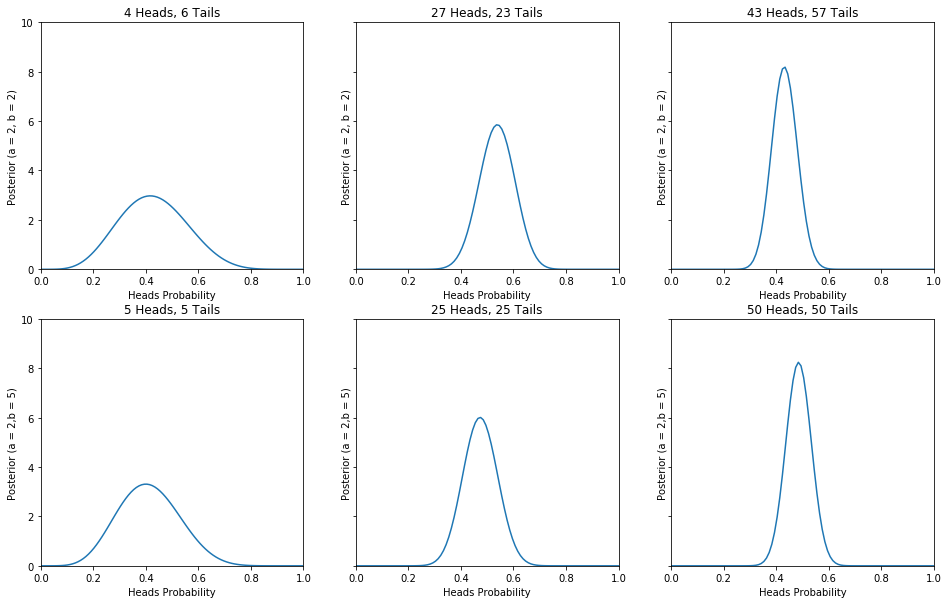

In [106]:
import numpy as np
from scipy import stats
from scipy.integrate import quad
import matplotlib.pyplot as plt

N = np.array([10,50,100])
th = np.linspace(0,1,100)
fig, axs = plt.subplots(2, 3, figsize=(16, 10), sharey=True)
def integrand(theta, N1, N2, alpha, beta):
    return (theta**(N1+alpha-1)*(1-theta)**(N2+beta-1))


for j in range(2):
    for i in range(3):
        if j==0:
            a_b = np.array([2,2])
        else:
            a_b = np.array([2,5])
        y = np.random.choice(2, N[i])    
        N_1 = np.count_nonzero(y==1)
        N_2 = np.count_nonzero(y==0)
        post_un = th**(N_1+a_b[0]-1)*(1-th)**(N_2+a_b[1]-1)
        post_int = quad(integrand, 0, 1, args=(N_1,N_2,a_b[0],a_b[1]))
        post_norm = post_un/post_int[0]

        axs[j,i].plot(th,post_norm)
        if j==0:
            axs[j,i].set_ylabel('Posterior (a = 2, b = 2)')
        else:
            axs[j,i].set_ylabel('Posterior (a = 2,b = 5)')
        axs[j,i].set_xlabel('Heads Probability')
        axs[j,i].set_ylim((0,10))
        axs[j,i].set_xlim((0,1))
        axs[j,i].set_title((str(N_1)+' Heads, '+str(N_2)+' Tails'))

### Comparison with Hypothesis Testing

In hypothesis testing:
1. We rely heavily on _p_-values and t-tests. 
2. Make assumption about normally distributed parameters.
3. What _p_-values to choose?
4. Does not provide density for parameter (mean).

In Bayesian inference:
1. Can update posterior density based on new data.
2. Provides density for parameter to characterize uncertainty.
3. Can assume noninformative prior for parameter (no normal distribution assumption needed).
4. Parameters may be used to quantify model uncertainty.